# Data Set : Bike Sharing Demand

# 1. 데이터 로드

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', 30)
from tqdm import tqdm

%matplotlib inline
plt.rc('font',family='Malgun Gothic')
import warnings
warnings.filterwarnings('ignore')
                        
bike_df = pd.read_csv('C:/Users/Park/_Python_data/bike_train.csv')
print(bike_df.shape)
bike_df.head(5)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 2. 데이터 가공

In [66]:
# object 타입을 datetime 타입으로 변경
# datetime 타입은 년, 월, 일, 시를 쉽게 분리할 수 있다.
# .apply(pd.to_datetime) : object(문자열)을 datetime으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# 년, 월, 일, 시간 추분리
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)

# casual 컬럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수
# registered 컬럼은 등록한 사용자의 자전거 대여 횟수
# count는 casual과 registered의 합으로 위 두 변수는 다중공선성만 증가시킬 뿐이므로 제거한다.

bike_df.drop(['datetime','casual','registered'],axis=1,inplace=True)

bike_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


<AxesSubplot:>

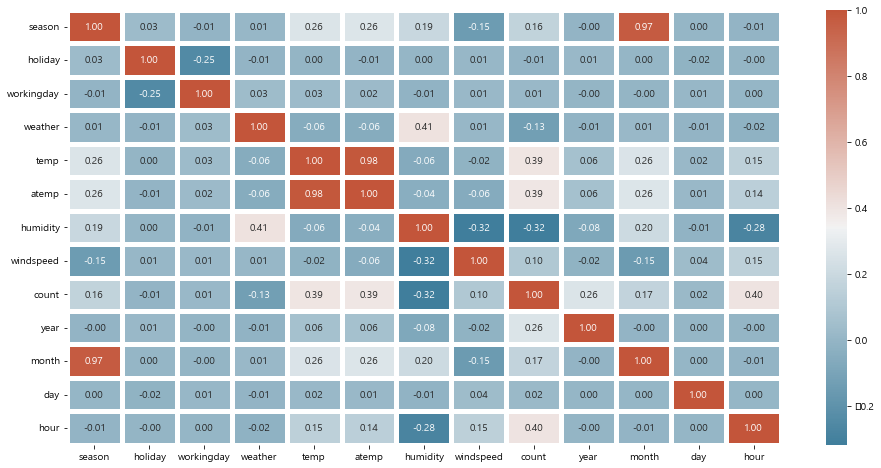

In [67]:
plt.figure(figsize=(16,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(bike_df.corr(), annot=True, cmap=cmap,linewidth=5,fmt='.2f',annot_kws={'size':10})

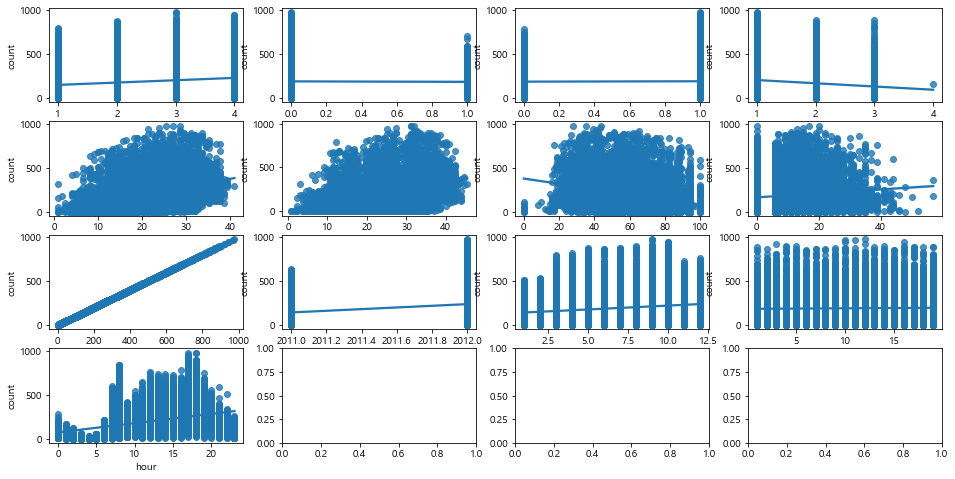

In [68]:
fig, axes = plt.subplots(4,4,figsize=(16,8))
feature = bike_df.columns

for i, feature in enumerate(feature):
    row = int(i/4)
    col = i%4
    sns.regplot(feature, 'count',data=bike_df, ax=axes[row][col])

# 3. 종합성능지표 및 회귀모델 적용 함수 생성

* 1. MSE
* 2. RMSE
* 3. RMSLE(Root Mean Square Log Error) : 오류값의 로그에 대한 RMse
  * 아웃라이어의 영향을 덜 받으며, 과소추정에 많은 패널티를 부여하는 측정치이다.
  * 이때 np.log1p() 함수를 사용하는데, 이는 로그값에 1을 더해주는것, 즉 1 + log()와 같다.
  * 이는 np.expm1() 함수로 원래의 스케일로 복원할 수 있다.
------------------------------------------------------------------------------
- 이를 모두 한번에 수행하는 함수 생성

In [5]:
# log 변환 시 NaN 등의 이슈로 log()가 아닌 log1p(자연로그)를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# RMSE 계산
def rmse(y,pred):
    rmse = np.sqrt(mean_squared_error(y,pred))
    return rmse

# MSE, RMSE, RMSLE, MAE 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mse_val = mean_squared_error(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MSE : {2:.3f}, MAE : {3:.3f}'.format(rmsle_val, rmse_val, mse_val, mae_val))
    
# 모델 학습 및 예측과 성능 평가 함수 생성
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):  # 디폴드값을 설정하는 것
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    # 만약 로그값이 존재하면 원래 스케일로 반환하라
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)
        
        

# 4. 데이터 전처리

## (1) 최초 회귀모델 구축 및 성능 평가

In [6]:
X = bike_df.drop(['count'], axis=1)
y= bike_df['count']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MSE : 19852.694, MAE : 105.924


* 성능 측정 결과 실제 target값을 감안했을 때 생각보다 오류값이 큰 것을 알 수 있다.
* 이에 잔차 값이 큰 것을 5개정도 확인해보자

In [7]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 컬럼으로 실제 대여 횟수와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])                       # target 실제값
    result_df['predict_count'] = np.round(pred)                                           # target 예측값
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predict_count'])      # target 실제값과 예측값의 차이
    
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff',ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)    

      real_count  predict_count   diff
1618         890          322.0  568.0
3151         798          241.0  557.0
966          884          327.0  557.0
412          745          194.0  551.0
2817         856          310.0  546.0


* 오차값이 500대임을 볼 때 예측 오류가 상당히 큰 것을 알 수 있다.
* 이때 예측 오류가 발생할 경우 target 데이터의 분포 형태가 정규분포 형태인지 확인하는 것이 우선적으로 필요하다

[Text(0.5, 1.0, 'log1p'), Text(0.5, 0, 'count'), Text(0, 0.5, 'density')]

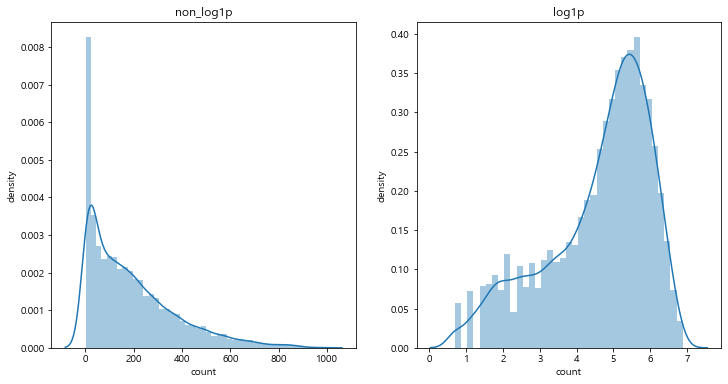

In [8]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
ax1 = axes[0]
ax2 = axes[1]

sns.distplot(y, ax=ax1)
sns.distplot(np.log1p(y), ax=ax2)
ax1.set(title = 'non_log1p', xlabel = 'count', ylabel='density')
ax2.set(title = 'log1p', xlabel = 'count', ylabel='density')


* log1p() 함수를 적용한 결과 일정부분 분포의 왜곡 정도가 해소된 것을 확인할 수 있다.
* 따라서 target 변수에 로그변환을 수행한 후 선형회귀 모델을 다시 학습해본다.
* 로그 변환하여 학습 후에는 원래 스케일로 변환해야 한다.

## (2) 로그변환

In [9]:
# Target 칼럼을 로그변환
y_log = np.log1p(y)

# 로그 변환된 Target 데이터를 반영하여 다시 회귀모델 구축

X_train, X_test, y_train, y_test = train_test_split(X,y_log,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

# test 데이터와 pred 데이터 모두 로그변환 되었으니 이를 다시 원래 스케일로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE : 1.017, RMSE : 162.594, MSE : 26436.896, MAE : 109.286


* RMSLE를 제외한 성과지표는 오히려 악화되었다..
* 회귀계수를 살펴보자.

<AxesSubplot:>

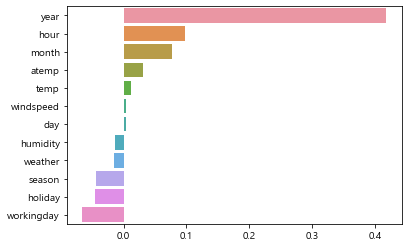

In [10]:
coef = pd.Series(lr_reg.coef_, index = X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x= coef_sort.values, y = coef_sort.index)

In [11]:
X.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,2012.000000,12.000000,19.000000,23.000000


* bar 플롯을 확인한 결과 year의 회귀계수가 독보적으로 큼을 알 수 있다.
* 그러나 연도별 자전거 대여 횟수가 크게 영향을 받는다는 것은 납들할 수 없다.
* 이러한 이유가 발생한 이유는 year의 데이터 타입이 숫자형이지만, 그 의미는 범주형(카테고리값)에 가깝기 때문이다.
* 따라서 이를 더미변수화(one-hot-encoding)를 통해 변환해야 한다.

## (3) 데이터 인코딩
* year 변수 이외에도 month, day, hour, holiday, workingday, season, weather 변수를 인코딩해준다.

In [12]:
X_enco = pd.get_dummies(X, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [13]:
X_enco

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hour_21,hour_22,hour_23,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0


# 5. 전처리 이후 모델 재학습

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_enco, y_log, test_size = 0.3, random_state = 0)

In [15]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MSE : 9542.850, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MSE : 9707.883, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MSE : 12818.499, MAE : 72.803


* 로그변환과 인코딩 후 모델의 학습능력이 크게 향상됨을 알 수 있다.
* 이제 상위 회귀계수 25개를 추출해보자

<AxesSubplot:>

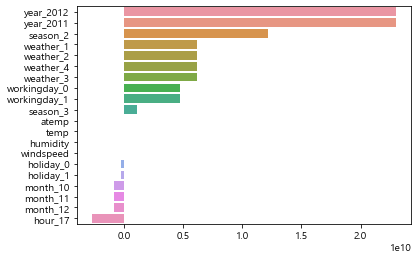

In [16]:
coef = pd.Series(lr_reg.coef_, index=X_enco.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x= coef_sort.values, y=coef_sort.index)

# 6. 최적 하이퍼파라미터 추정

In [17]:
parameter = {'alpha' : np.arange(0.1,10,0.1)}

In [18]:
ridge_grid = GridSearchCV(ridge_reg, param_grid = parameter, cv=5, refit=True)
ridge_grid.fit(X_train,y_train)
lasso_grid = GridSearchCV(lasso_reg, param_grid = parameter, cv=5, refit=True)
lasso_grid.fit(X_train,y_train)

print('ridge 최적 파라미터',ridge_grid.best_params_)
print('lasso 최적 파라미터',lasso_grid.best_params_)

ridge 최적 파라미터 {'alpha': 0.2}
lasso 최적 파라미터 {'alpha': 0.1}


In [103]:
ridge_reg = Ridge(alpha=0.2)
ridge_reg.fit(X_train,y_train)
ridge_pred = ridge_reg.predict(X_test)

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train,y_train)
lasso_pred = lasso_reg.predict(X_test)

print('----Ridge 결과----')
evaluate_regr(np.expm1(y_test),np.expm1(ridge_pred))
print('----Lasso 결과----')
evaluate_regr(np.expm1(y_test),np.expm1(lasso_pred))

----Ridge 결과----
RMSLE : 0.590, RMSE : 97.698, MSE : 9544.996, MAE : 63.388
----Lasso 결과----
RMSLE : 1.227, RMSE : 174.258, MSE : 30365.899, MAE : 119.504


In [108]:
params = {'n_estimators' : [1000],
         'max_depth' : [3,6,8],
         'min_samples_split' : [2,4,8]}

rdf_grid = GridSearchCV(rdf, param_grid = params, cv=3, scoring = 'neg_mean_squared_error')
rdf_grid.fit(X_train,y_train)
rdf_grid_result = rdf_grid.best_params_
rdf_grid_score = rdf_grid.best_score_

print('랜덤포레스트 최적 하이퍼 파라미터 :', rdf_grid_result)
print('최적 파라미터 RMSLE :', np.sqrt(-rdf_grid_score))

랜덤포레스트 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 1000}
최적 파라미터 RMSLE : 0.6616077445182938


In [109]:
evals = [(X_train, y_train)]

xgb = XGBRegressor(n_estimators = 1000, eval_matric = 'rmse',learning_rate = 0.1)
xgb.fit(X_train,y_train, 
       early_stopping_rounds = 50,
       eval_set = evals,
       verbose = 1)
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

print(evaluate_regr(np.expm1(y_train), np.expm1(xgb_train_pred)))
print(evaluate_regr(np.expm1(y_test),np.expm1(xgb_test_pred)))

[14:08:19] WARNING: ..\src\learner.cc:576: 
Parameters: { "eval_matric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:3.90537
[1]	validation_0-rmse:3.53238
[2]	validation_0-rmse:3.19808
[3]	validation_0-rmse:2.89928
[4]	validation_0-rmse:2.63187
[5]	validation_0-rmse:2.39310
[6]	validation_0-rmse:2.17939
[7]	validation_0-rmse:1.98836
[8]	validation_0-rmse:1.81765
[9]	validation_0-rmse:1.66591
[10]	validation_0-rmse:1.53080
[11]	validation_0-rmse:1.40888
[12]	validation_0-rmse:1.30252
[13]	validation_0-rmse:1.20628
[14]	validation_0-rmse:1.12260
[15]	validation_0-rmse:1.04129
[16]	validation_0-rmse:0.97410
[17]	validation_0-rmse:0.91271
[18]	validation_0-rmse:0.86050
[19]	validation_0-rmse:0.80895
[20]	validation_0-rmse:0.764

[249]	validation_0-rmse:0.18624
[250]	validation_0-rmse:0.18588
[251]	validation_0-rmse:0.18562
[252]	validation_0-rmse:0.18552
[253]	validation_0-rmse:0.18541
[254]	validation_0-rmse:0.18511
[255]	validation_0-rmse:0.18421
[256]	validation_0-rmse:0.18381
[257]	validation_0-rmse:0.18332
[258]	validation_0-rmse:0.18298
[259]	validation_0-rmse:0.18263
[260]	validation_0-rmse:0.18255
[261]	validation_0-rmse:0.18226
[262]	validation_0-rmse:0.18193
[263]	validation_0-rmse:0.18142
[264]	validation_0-rmse:0.18103
[265]	validation_0-rmse:0.18096
[266]	validation_0-rmse:0.18059
[267]	validation_0-rmse:0.18016
[268]	validation_0-rmse:0.17994
[269]	validation_0-rmse:0.17981
[270]	validation_0-rmse:0.17965
[271]	validation_0-rmse:0.17943
[272]	validation_0-rmse:0.17919
[273]	validation_0-rmse:0.17906
[274]	validation_0-rmse:0.17886
[275]	validation_0-rmse:0.17859
[276]	validation_0-rmse:0.17837
[277]	validation_0-rmse:0.17789
[278]	validation_0-rmse:0.17759
[279]	validation_0-rmse:0.17706
[280]	va

[506]	validation_0-rmse:0.13165
[507]	validation_0-rmse:0.13157
[508]	validation_0-rmse:0.13153
[509]	validation_0-rmse:0.13138
[510]	validation_0-rmse:0.13131
[511]	validation_0-rmse:0.13129
[512]	validation_0-rmse:0.13119
[513]	validation_0-rmse:0.13113
[514]	validation_0-rmse:0.13107
[515]	validation_0-rmse:0.13102
[516]	validation_0-rmse:0.13078
[517]	validation_0-rmse:0.13054
[518]	validation_0-rmse:0.13041
[519]	validation_0-rmse:0.13022
[520]	validation_0-rmse:0.13003
[521]	validation_0-rmse:0.12998
[522]	validation_0-rmse:0.12973
[523]	validation_0-rmse:0.12951
[524]	validation_0-rmse:0.12944
[525]	validation_0-rmse:0.12930
[526]	validation_0-rmse:0.12915
[527]	validation_0-rmse:0.12907
[528]	validation_0-rmse:0.12878
[529]	validation_0-rmse:0.12860
[530]	validation_0-rmse:0.12854
[531]	validation_0-rmse:0.12833
[532]	validation_0-rmse:0.12814
[533]	validation_0-rmse:0.12790
[534]	validation_0-rmse:0.12771
[535]	validation_0-rmse:0.12744
[536]	validation_0-rmse:0.12736
[537]	va

[763]	validation_0-rmse:0.09896
[764]	validation_0-rmse:0.09884
[765]	validation_0-rmse:0.09869
[766]	validation_0-rmse:0.09850
[767]	validation_0-rmse:0.09832
[768]	validation_0-rmse:0.09818
[769]	validation_0-rmse:0.09800
[770]	validation_0-rmse:0.09786
[771]	validation_0-rmse:0.09777
[772]	validation_0-rmse:0.09770
[773]	validation_0-rmse:0.09768
[774]	validation_0-rmse:0.09756
[775]	validation_0-rmse:0.09753
[776]	validation_0-rmse:0.09749
[777]	validation_0-rmse:0.09746
[778]	validation_0-rmse:0.09738
[779]	validation_0-rmse:0.09728
[780]	validation_0-rmse:0.09723
[781]	validation_0-rmse:0.09720
[782]	validation_0-rmse:0.09712
[783]	validation_0-rmse:0.09700
[784]	validation_0-rmse:0.09696
[785]	validation_0-rmse:0.09689
[786]	validation_0-rmse:0.09687
[787]	validation_0-rmse:0.09685
[788]	validation_0-rmse:0.09684
[789]	validation_0-rmse:0.09667
[790]	validation_0-rmse:0.09658
[791]	validation_0-rmse:0.09653
[792]	validation_0-rmse:0.09651
[793]	validation_0-rmse:0.09650
[794]	va

In [110]:
evals = [(X_train, y_train)]

lgbm = LGBMRegressor(n_estimators = 1000,eval_matric = 'rmse', learning_rate = 0.1)
lgbm.fit(X_train,y_train, 
      early_stopping_rounds = 100,
       eval_set = evals,
       verbose = 1)
lgbm_train_pred = lgbm.predict(X_train)
lgbm_test_pred = lgbm.predict(X_test)

print(evaluate_regr(np.expm1(y_train), np.expm1(lgbm_train_pred)))
print(evaluate_regr(np.expm1(y_test),np.expm1(lgbm_test_pred)))

[LightGBM] [Warning] Unknown parameter: eval_matric
[1]	training's l2: 1.696
[2]	training's l2: 1.44309
[3]	training's l2: 1.23526
[4]	training's l2: 1.06289
[5]	training's l2: 0.924425
[6]	training's l2: 0.806229
[7]	training's l2: 0.70866
[8]	training's l2: 0.631078
[9]	training's l2: 0.563517
[10]	training's l2: 0.507537
[11]	training's l2: 0.462907
[12]	training's l2: 0.427879
[13]	training's l2: 0.396912
[14]	training's l2: 0.369932
[15]	training's l2: 0.348238
[16]	training's l2: 0.330818
[17]	training's l2: 0.312649
[18]	training's l2: 0.295686
[19]	training's l2: 0.281345
[20]	training's l2: 0.270583
[21]	training's l2: 0.256049
[22]	training's l2: 0.244551
[23]	training's l2: 0.235114
[24]	training's l2: 0.226329
[25]	training's l2: 0.215635
[26]	training's l2: 0.209065
[27]	training's l2: 0.199105
[28]	training's l2: 0.192216
[29]	training's l2: 0.184375
[30]	training's l2: 0.179348
[31]	training's l2: 0.170645
[32]	training's l2: 0.167479
[33]	training's l2: 0.163479
[34]	tr

[400]	training's l2: 0.0402866
[401]	training's l2: 0.0402273
[402]	training's l2: 0.0401698
[403]	training's l2: 0.0400979
[404]	training's l2: 0.0400133
[405]	training's l2: 0.0399797
[406]	training's l2: 0.0398954
[407]	training's l2: 0.0397852
[408]	training's l2: 0.0396404
[409]	training's l2: 0.0395334
[410]	training's l2: 0.0394544
[411]	training's l2: 0.0393235
[412]	training's l2: 0.0392467
[413]	training's l2: 0.0391735
[414]	training's l2: 0.0390729
[415]	training's l2: 0.039
[416]	training's l2: 0.0389273
[417]	training's l2: 0.0388243
[418]	training's l2: 0.0387356
[419]	training's l2: 0.0386255
[420]	training's l2: 0.0385668
[421]	training's l2: 0.0384637
[422]	training's l2: 0.0383824
[423]	training's l2: 0.0383035
[424]	training's l2: 0.0382235
[425]	training's l2: 0.0381593
[426]	training's l2: 0.0380775
[427]	training's l2: 0.0380092
[428]	training's l2: 0.0379523
[429]	training's l2: 0.037885
[430]	training's l2: 0.0378216
[431]	training's l2: 0.0377575
[432]	trainin

[889]	training's l2: 0.0208473
[890]	training's l2: 0.0208303
[891]	training's l2: 0.0208197
[892]	training's l2: 0.0208024
[893]	training's l2: 0.0207829
[894]	training's l2: 0.0207657
[895]	training's l2: 0.020742
[896]	training's l2: 0.020732
[897]	training's l2: 0.0206998
[898]	training's l2: 0.0206758
[899]	training's l2: 0.0206639
[900]	training's l2: 0.0206465
[901]	training's l2: 0.0206215
[902]	training's l2: 0.0205968
[903]	training's l2: 0.0205737
[904]	training's l2: 0.0205387
[905]	training's l2: 0.0205013
[906]	training's l2: 0.0204907
[907]	training's l2: 0.0204648
[908]	training's l2: 0.0204364
[909]	training's l2: 0.0204239
[910]	training's l2: 0.0204052
[911]	training's l2: 0.0203832
[912]	training's l2: 0.0203725
[913]	training's l2: 0.0203577
[914]	training's l2: 0.0203428
[915]	training's l2: 0.0203156
[916]	training's l2: 0.0202963
[917]	training's l2: 0.0202768
[918]	training's l2: 0.0202487
[919]	training's l2: 0.0202246
[920]	training's l2: 0.0201999
[921]	trai

In [107]:
print('Random Forest RMSLE', round(np.sqrt(-rdf_grid_score),4))
print('XGBoost RMSLE', round(np.sqrt(mean_squared_error(y_test,xgb_test_pred)),4))
print('LightGBM RMSLE', round(np.sqrt(mean_squared_error(y_test,lgbm_test_pred)),4))

Random Forest RMSLE 0.6614
XGBoost RMSLE 0.3236
LightGBM RMSLE 0.3207


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

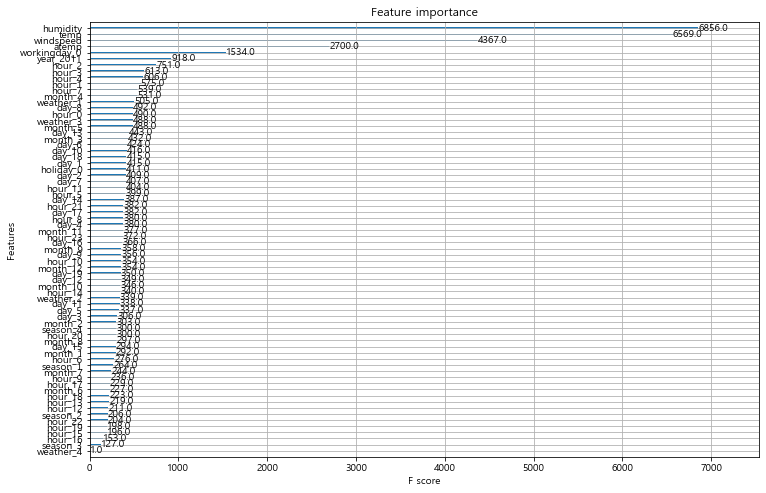

In [93]:
fig, ax = plt.subplots(figsize = (12,8))
plot_importance(xgb,ax=ax)